本次上机作业一共包含以下几个步骤：

基于上机作业3所收集到的语料库（corpus），

1. 采用bag of words，n-grams 和 TF-IDF的方法进行特征提取；

2. 采用Latent Dirichlet Allocation（LDA）进行主题提取，并利用pyLDAvis库进行主题可视化；

3. 采用词云（Wordcloud）技术对分别对3个文档（document）进行文本可视化；

4. 最后从以上的可视化结果中，总结出与主题相关的结论。

# 0. Preparation

In [1]:
import pandas as pd
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')

1. 读取上机作业3得到的tokens文件

In [2]:
d1 = pd.read_csv('./tokens/Tokens1.txt', header=None)
d2 = pd.read_csv('./tokens/Tokens2.txt', header=None)
d3 = pd.read_csv('./tokens/Tokens3.txt', header=None)

In [3]:
documents = {
    'doc1': list(d1[0]),
    'doc2': list(d2[0]),
    'doc3': list(d3[0]),     
}

2. 自定义一些stop words，从tokens中去除

In [4]:
stop_list = ['!', "'re", "'s", '110km', '2.1', '2021', '45', '50']
documents = {key: [v for v in value if v not in stop_list]for key, value in documents.items()}

# 1. Text Feature Extraction

## 1.1. Bag of Words

1. Count the tokens for each document

In [5]:
counts = {doc_label: Counter(tokens) for doc_label, tokens in documents.items()}

2. Extract the vocabulary (set of unique terms in all documents)

In [6]:
def create_vocab(documents):
    vocab = set()
    for tokens in documents.values():
        vocab |= set(tokens)
    stopwords = nltk.corpus.stopwords.words('english')
    return vocab - set(stopwords)

In [7]:
vocab = create_vocab(documents)

3. Create the BoW matrix

In [8]:
def create_bow(counts, vocab):
    bow = []
    for counter in counts.values():
        bow.append([counter.get(term, 0) for term in vocab])
    return bow

In [9]:
bow = create_bow(counts, vocab)

In [10]:
df_bow = pd.DataFrame(bow).T
df_bow.columns = documents.keys()
df_bow.index = vocab
df_bow.head()

,doc1,doc2,doc3
planned,1,0,0
northern,0,1,0
war,0,0,1
prompting,0,0,1
judas,0,1,0


4. Plot the heatmap.

因为3个documents的语料库不太重合，词汇表又比较长，所以我分别对3个document的词频进行降序，花了3张热力图。

In [11]:
def plot_heatmap(bow, xticklabels, yticklabels, title=''):
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(bow, cmap='Blues')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(range(len(yticklabels)))
    ax.set_yticklabels(yticklabels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(yticklabels)):
        if bow.shape[0] == 1:
            for j, text in enumerate(bow.values[0]):
                ax.text(j, i, round(text, 4), ha="center", va="center", color='r')
        else:
            for j, text in enumerate(bow[i:(i + 1)].values[0]):
                ax.text(j, i, round(text, 4), ha="center", va="center", color='r')

    plt.xlabel('Terms')
    plt.ylabel('Documents')
    plt.title(title)

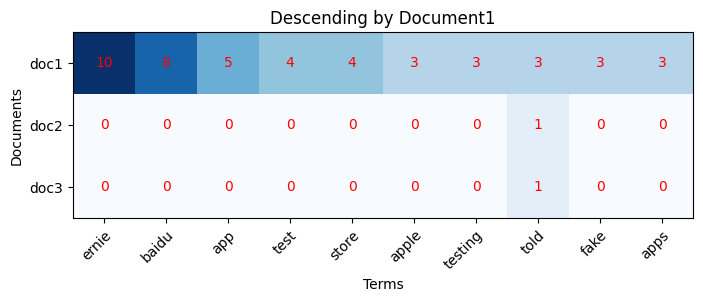

In [12]:
plot_heatmap(df_bow.sort_values(by='doc1', ascending=False)[:10].T,
             df_bow.sort_values(by='doc1', ascending=False)[:10].index,
             documents.keys(), 'Descending by Document1')

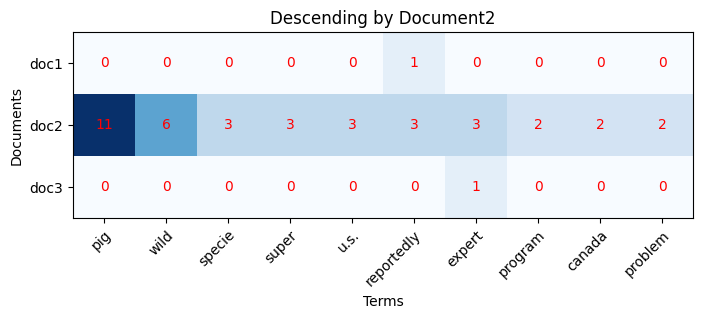

In [13]:
plot_heatmap(df_bow.sort_values(by='doc2', ascending=False)[:10].T,
             df_bow.sort_values(by='doc2', ascending=False)[:10].index,
             documents.keys(), 'Descending by Document2')

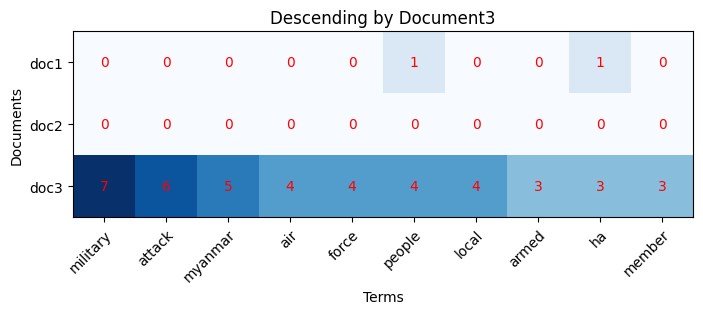

In [14]:
plot_heatmap(df_bow.sort_values(by='doc3', ascending=False)[:10].T,
             df_bow.sort_values(by='doc3', ascending=False)[:10].index,
             documents.keys(), 'Descending by Document3')

## 1.2. n-grams

1. Count the n-grams for each document. Here we set n as 2.

In [15]:
documents_bi = {doc_label: doc_token + 
                [' '.join(terms) for terms in ngrams(doc_token, n=2)] 
                for doc_label, doc_token in documents.items()}

2. Create bigrams vocabulary

In [16]:
vocab_bi = create_vocab(documents_bi)

3. Create bigrams matrix

In [17]:
counts_bi = {doc_label: Counter(tokens) for doc_label, tokens in documents_bi.items()}

In [18]:
bow_bi = create_bow(counts_bi, vocab_bi)

In [19]:
df_bow_bi = pd.DataFrame(bow_bi).T
df_bow_bi.columns = documents_bi.keys()
df_bow_bi.index = vocab_bi
df_bow_bi.head()

,doc1,doc2,doc3
ernie profit,1,0,0
planned,1,0,0
characterised united,0,0,1
northern,0,1,0
war,0,0,1


4. Plot the heatmap.

因为3个documents的语料库不太重合，词汇表又比较长，所以我分别对3个document的词频进行降序，花了3张热力图。

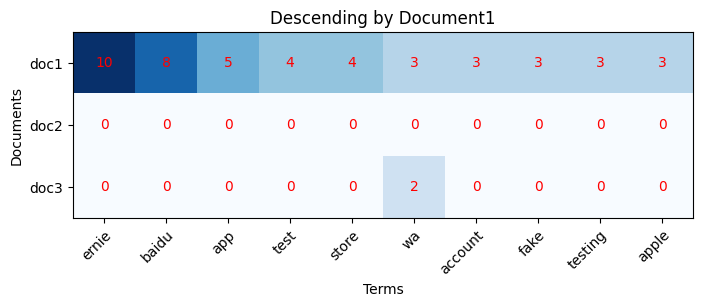

In [20]:
plot_heatmap(df_bow_bi.sort_values(by='doc1', ascending=False)[:10].T,
             df_bow_bi.sort_values(by='doc1', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document1')

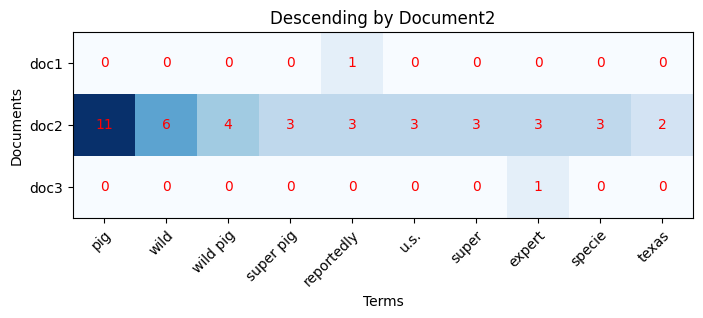

In [21]:
plot_heatmap(df_bow_bi.sort_values(by='doc2', ascending=False)[:10].T,
             df_bow_bi.sort_values(by='doc2', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document2')

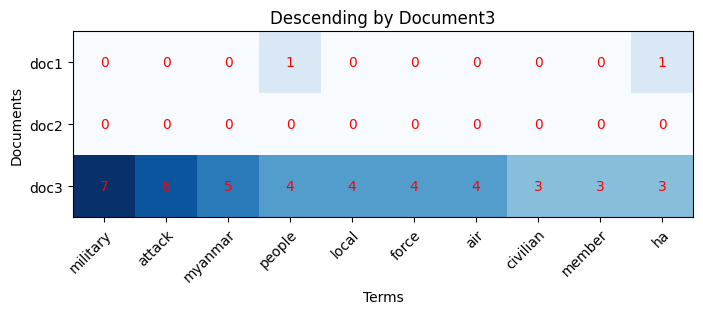

In [22]:
plot_heatmap(df_bow_bi.sort_values(by='doc3', ascending=False)[:10].T,
             df_bow_bi.sort_values(by='doc3', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document3')

## 1.3. TF-IDF

### 1.3.1. TF

1. Calculate TF

In [23]:
raw_counts = np.mat(bow_bi, dtype=float)
tf = raw_counts / np.sum(raw_counts, axis=1)

2. Plot heatmap

因为3个documents的语料库不太重合，词汇表又比较长，所以我分别对3个document的TF进行降序，花了3张热力图。

In [24]:
df_tf = pd.DataFrame(tf).T
df_tf.columns = documents_bi.keys()
df_tf.index = vocab_bi
df_tf.head()

,doc1,doc2,doc3
ernie profit,0.002597,0.000000,0.000000
planned,0.002597,0.000000,0.000000
characterised united,0.000000,0.000000,0.002132
northern,0.000000,0.003322,0.000000
war,0.000000,0.000000,0.002132


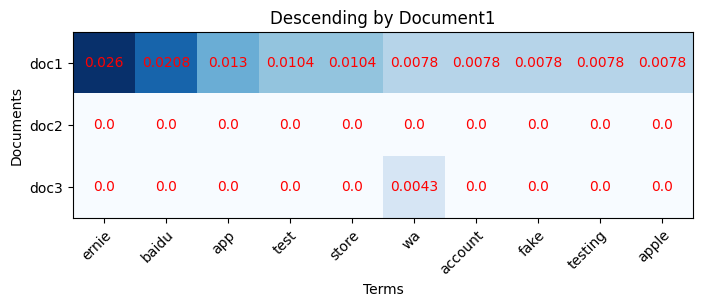

In [25]:
plot_heatmap(df_tf.sort_values(by='doc1', ascending=False)[:10].T,
             df_tf.sort_values(by='doc1', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document1')

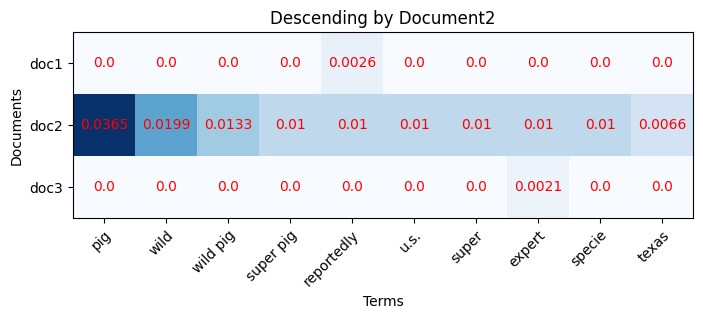

In [26]:
plot_heatmap(df_tf.sort_values(by='doc2', ascending=False)[:10].T,
             df_tf.sort_values(by='doc2', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document2')

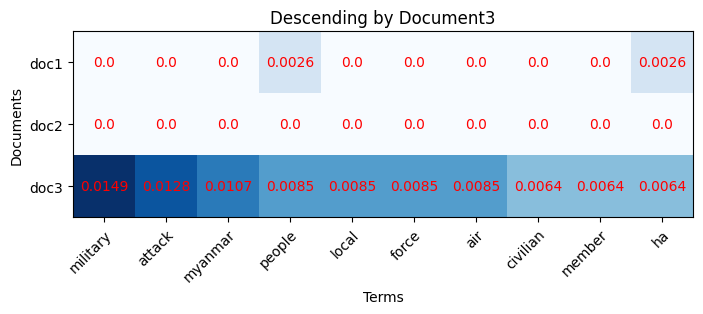

In [27]:
plot_heatmap(df_tf.sort_values(by='doc3', ascending=False)[:10].T,
             df_tf.sort_values(by='doc3', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document3')

### 1.3.2. IDF

1. Calculate IDF

In [28]:
def num_terms_in_docs(t, docs):
    return sum(t in d for d in docs.values())

In [29]:
def idf(t, docs):
    return np.log(len(docs) / num_terms_in_docs(t, docs))

In [30]:
idf_row = [idf(t, documents_bi) for t in vocab_bi]

2. Plot heatmap

我对IDF降序、升序分别画了热力图。

In [31]:
df_idf = pd.DataFrame(idf_row)
df_idf.columns = ['IDF']
df_idf.index = vocab_bi
df_idf.head()

,IDF
ernie profit,1.098612
planned,1.098612
characterised united,1.098612
northern,1.098612
war,1.098612


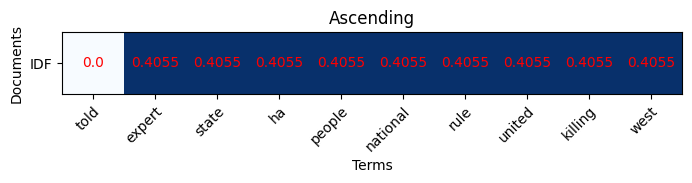

In [32]:
plot_heatmap(df_idf.sort_values(by='IDF')[:10].T,
             df_idf.sort_values(by='IDF')[:10].index,
             ['IDF'], 'Ascending')

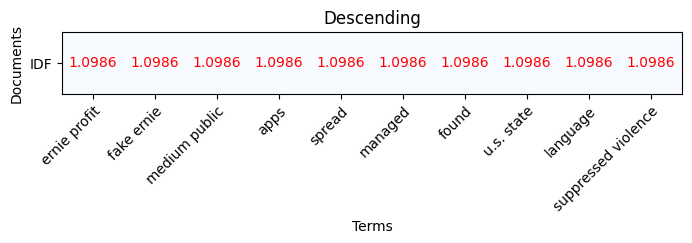

In [33]:
plot_heatmap(df_idf.sort_values(by='IDF', ascending=False)[:10].T,
             df_idf.sort_values(by='IDF', ascending=False)[:10].index,
             ['IDF'], 'Descending')

### 1.3.3. TF-IDF

1. Calculate TF-IDF

In [34]:
tfidf = tf * np.diag(idf_row)

2. Plot heatmap

因为3个documents的语料库不太重合，词汇表又比较长，所以我分别对3个document的TF-IDF进行降序，花了3张热力图。

In [35]:
df_tfidf = pd.DataFrame(tfidf).T
df_tfidf.columns = documents_bi.keys()
df_tfidf.index = vocab_bi
df_tfidf.head()

,doc1,doc2,doc3
ernie profit,0.002854,0.00000,0.000000
planned,0.002854,0.00000,0.000000
characterised united,0.000000,0.00000,0.002342
northern,0.000000,0.00365,0.000000
war,0.000000,0.00000,0.002342


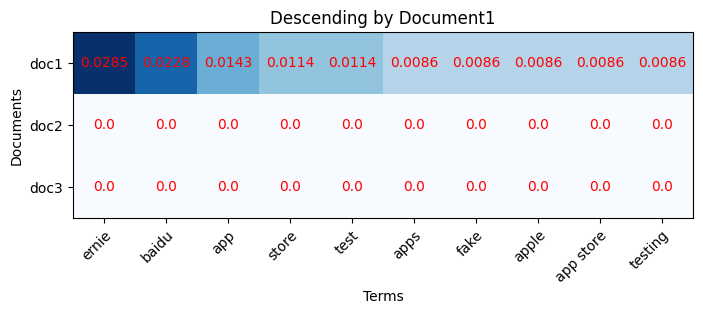

In [36]:
plot_heatmap(df_tfidf.sort_values(by='doc1', ascending=False)[:10].T,
             df_tfidf.sort_values(by='doc1', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document1')

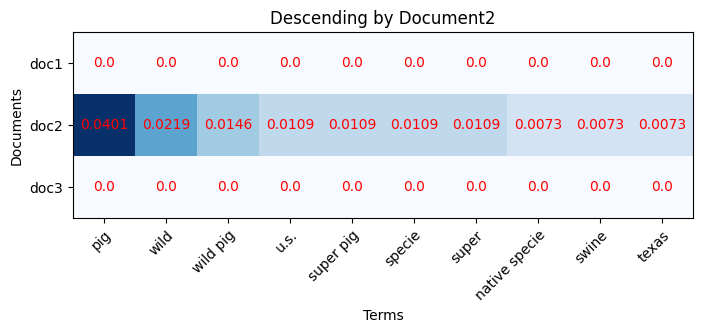

In [37]:
plot_heatmap(df_tfidf.sort_values(by='doc2', ascending=False)[:10].T,
             df_tfidf.sort_values(by='doc2', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document2')

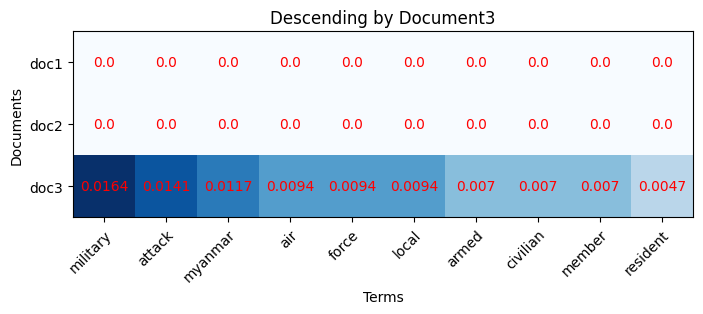

In [38]:
plot_heatmap(df_tfidf.sort_values(by='doc3', ascending=False)[:10].T,
             df_tfidf.sort_values(by='doc3', ascending=False)[:10].index,
             documents_bi.keys(), 'Descending by Document3')

# 2. Latent Dirichlet Allocation（LDA）

1. Read the raw data

In [39]:
def read_doc(path):
    with open(path, 'r') as f:
        doc = ''.join([line for line in f]).replace('\n', ' ')
    return doc

In [40]:
docs_raw = [read_doc('corpus/Baidu sues Apple.txt'),
            read_doc('corpus/Canadian super pigs.txt'),
            read_doc('corpus/Myanmar military air attacks.txt')]

2. Convert to document-term matrix

这里和之前不同，我用了sklearn中tfidf的包来做。

In [49]:
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                   stop_words = 'english',
                                   lowercase = True,
                                   token_pattern = r'\b[a-zA-Z]{3,}\b')
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

3. Fit Latent Dirichlet Allocation model

因为有3篇文档，而且我选的这3篇主题非常不同，我就将n_components定为了3。

In [50]:
lda = LatentDirichletAllocation(n_components=3)
lda.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=3)

4. Proportion of each topic in each document

In [51]:
doc_topic = lda.transform(dtm_tfidf)
doc_topic

array([[0.9276993 , 0.03616242, 0.03613828],
       [0.03683589, 0.9263858 , 0.03677831],
       [0.02896606, 0.02895322, 0.94208071]])

5. Visualize LDA model

可以看到3个主题在降维图上两两差距都很大，而且对应的word distribution也非常不同，与预期相符。

In [52]:
pyLDAvis.lda_model.prepare(lda, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.002080  0.000548       1        1  39.319622
0      0.000548 -0.002012       2        1  30.743423
1      0.001532  0.001464       3        1  29.936955, topic_info=          Term     Freq    Total Category  logprob  loglift
286       pigs  0.00000  0.00000  Default  30.0000  30.0000
137      ernie  0.00000  0.00000  Default  29.0000  29.0000
46       baidu  0.00000  0.00000  Default  28.0000  28.0000
429       wild  0.00000  0.00000  Default  27.0000  27.0000
27         app  0.00000  0.00000  Default  26.0000  26.0000
..         ...      ...      ...      ...      ...      ...
37   assistant  0.02242  0.06671   Topic3  -5.9841   0.1157
41   attempted  0.02242  0.06671   Topic3  -5.9841   0.1157
42    attempts  0.02242  0.06671   Topic3  -5.9841   0.1157
53    believes  0.02242  0.06671   Topic3  -5.9841   0.1157
54         big  0.02242  0.06671   Topic3  -5.9841   0.1157

[122 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

# 3. Word Cloud

1. 将word list用空格连接为字符串

In [53]:
text1 = ' '.join(documents['doc1'])
text2 = ' '.join(documents['doc2'])
text3 = ' '.join(documents['doc3'])
text = text1 + text2 + text3

2. 把3篇文档合起来画一个词云图

In [54]:
def plot_wordcloud(background_path, text, cmap=None):
    background_image = np.array(Image.open(background_path))
    if not cmap:
        wordcloud = WordCloud(
            mask=background_image,
            max_words=200,
            background_color='white'
        ).generate(text)
        image_colors = ImageColorGenerator(background_image)
        wordcloud.recolor(color_func=image_colors)
    else:
        wordcloud = WordCloud(
            mask=background_image,
            max_words=200,
            background_color='white',
            colormap=cmap
        ).generate(text)
    return wordcloud

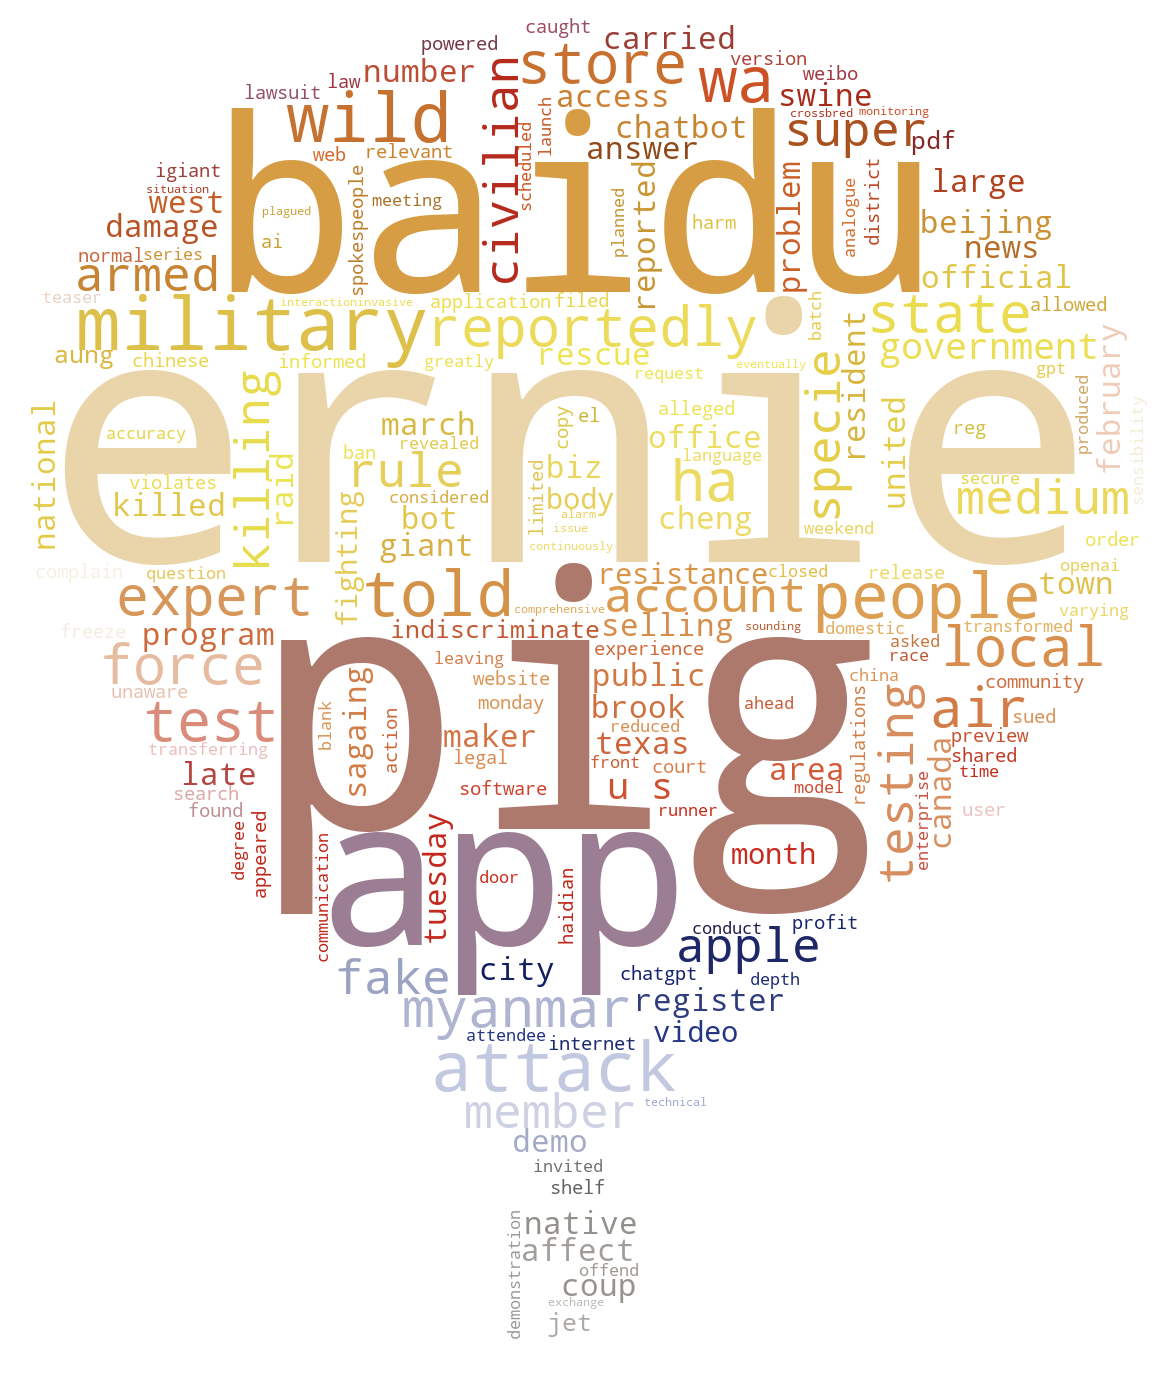

In [55]:
wc = plot_wordcloud('./backgrounds/bg.jpg', text)
wc.to_image()

3. 对3篇文档分别画出词云图

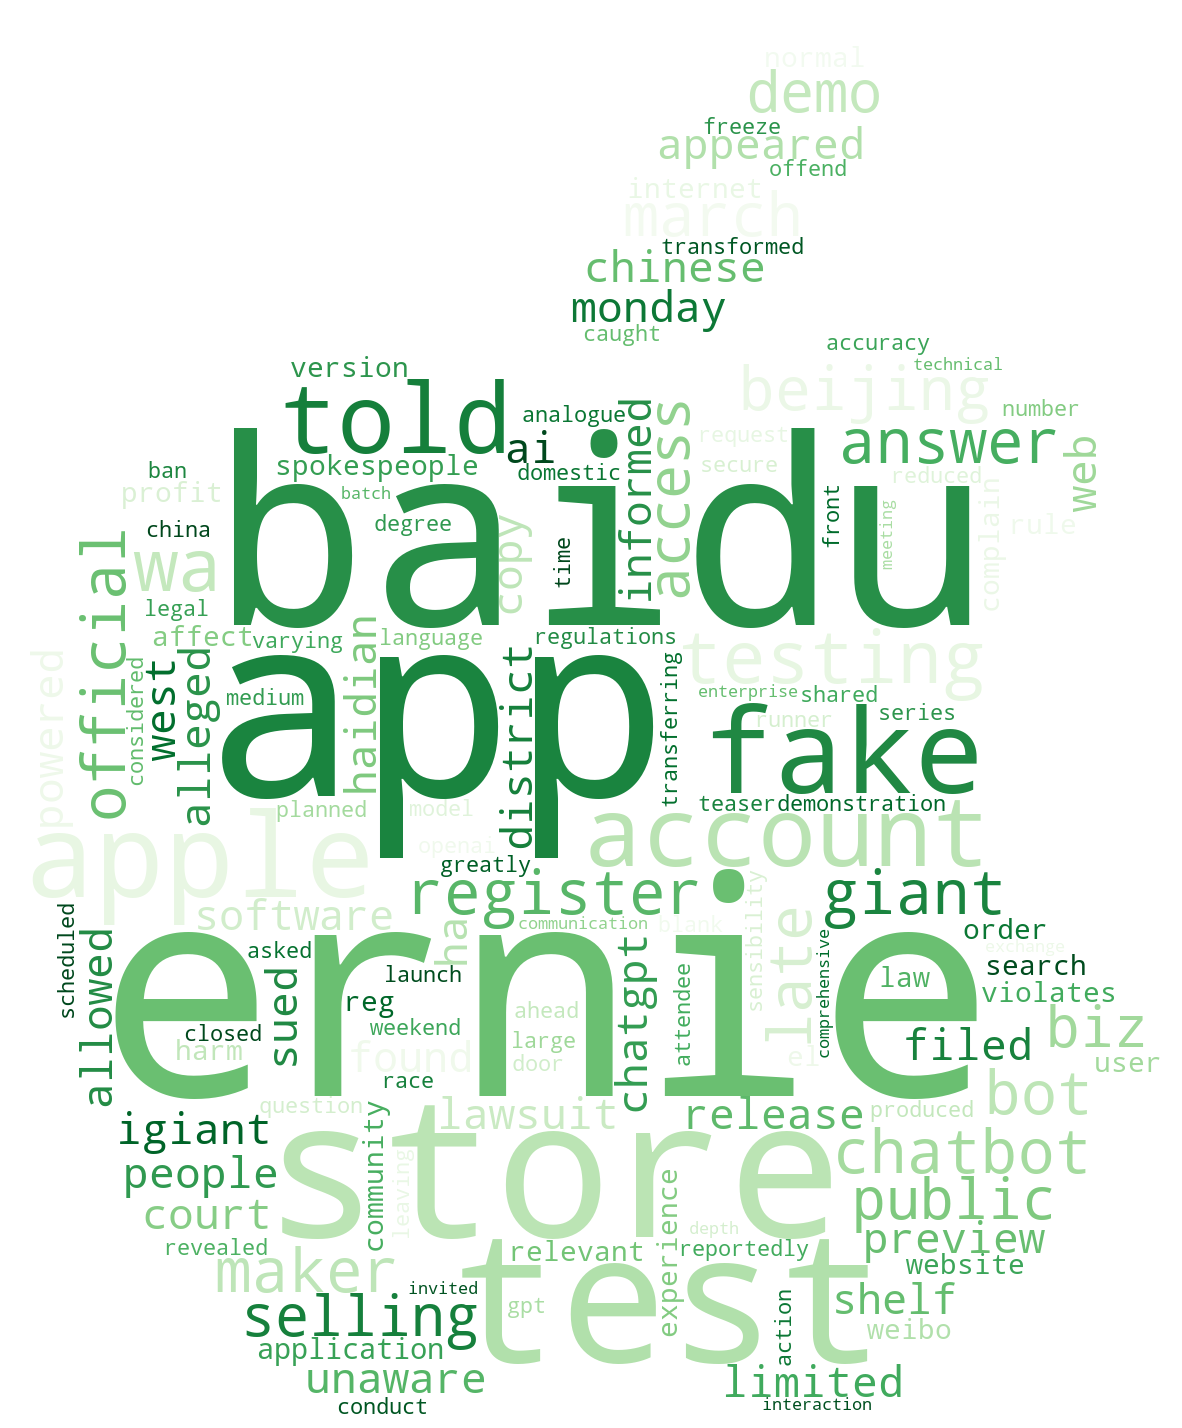

In [56]:
wc1 = plot_wordcloud('./backgrounds/bg1.jpg', text1, 'Greens')
wc1.to_image()

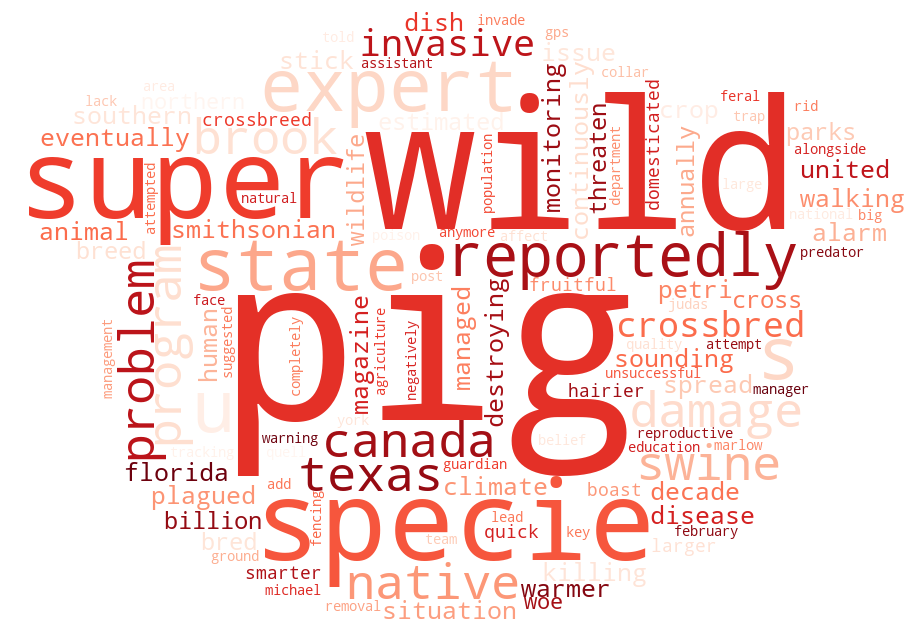

In [57]:
wc2 = plot_wordcloud('./backgrounds/bg2.jpg', text2, cmap='Reds')
wc2.to_image()

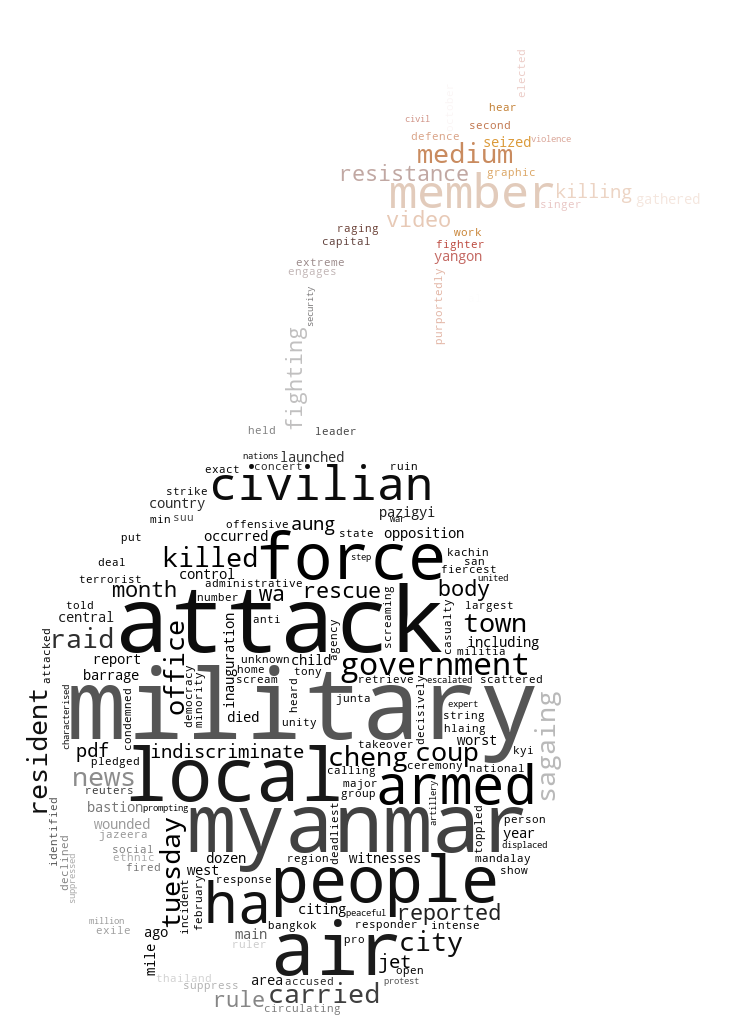

In [58]:
wc3 = plot_wordcloud('./backgrounds/bg3.jpg', text3)
wc3.to_image()

# 4. 结论

1. 特征提取部分：
- 在BoW和n-grams模型中，我分别对3篇文档的词频降序后取前10画出了热力图，从图中可以看出，3篇文档没有重复的高频词，提取出的特征差异较大。
- 在TF-IDF模型中，我分了3步计算：首先计算TF并对其可视化，结论与上一条相同；然后计算IDF，对其分别降序、升序取前10画了热力图，发现IDF最低的几个词都不具备代表性，例如told, number, people等等，我们从中难以提取主题相关的信息，而IDF最高的几个词则比较清楚地反映了主题的部分内容，例如ernie, baidu等等；最后计算TF-IDF，结论和之前一致。
2. LDA模型：
- 因为我选择的3篇文档主题都非常不同，所以我令LatentDirichletAllocation的n_components参数定为3。
- 然后查看每篇文档中3个主题的比例，发现都存在一个主题的比例高达90\%，说明这3篇文档的主题都很清晰。
- 从LDA可视化中，在PCA降维图中可以看到3个主题的两两差距都很大，在右侧图中可以看到每个主题对应的word distribution也非常不同，这与预期是相符的。
3. 词云图：
- 在总的词云图中，可以看到baidu, ernie, pig是高频词，前2者来自于第一篇文档，后者来自于第二篇文档，而第三篇文档的高频词则不是很明显，这可能是因为第三篇文档重要单词的重复率没有前两篇文章高。
- 对3篇文档分别画出词云图，第1篇文档讲的是Baidu sues Apple，高频词有baidu, ernie, app, store, test, fake等；第2篇文章讲的是Canadian super pigs，高频词有pig, wild, super, expert等；第3篇文章讲的是Myanmar military air attacks，高频词有military, attack, myanmar, force, armed等。由此可见，词云能够清晰地展示出每个文档的主题是什么，且我们可以通过比较不同文档的词云图来比较不同文档主题之间的差异，因此词云是很好的文本可视化工具。